Improvements:
* modularize
* automate file names to whatever is downloaded from roboflow/youtube
* add to hugging face and add in model tracking
* write paper on it
* combine court and bball models to see if you can filter for just the players on the court
* track the ball and see if we can get when it goes into the hoop
* segment the shoes to see if we can get an approximation of their distance to the hoop

Workflow:
1) download roboflow dataset
2) pull in helper functions
3) customcocodataset
4) load classes
5) load r-cnn model
6) load data in the custom dataset
7) load into dataloaders
8) optimizer/loss_function
9) train/eval
10) use on custom image
11) use on custom video

In [101]:
%%writefile going_modular/utils.py
#!pip install roboflow

#from roboflow import Roboflow
#rf = Roboflow(api_key="htpcxp3XQh7SsgMfjJns")
#project = rf.workspace("ai-79z1a").project("basketball_child")
#dataset = project.version(6).download("coco-segmentation")


from roboflow import Roboflow
import torch
import requests

def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"


def get_project(api_key, workspace, project_name, version):
    rf = Roboflow(api_key=api_key)
    project = rf.workspace(workspace).project(project_name)
    dataset = project.version(version).download("coco-segmentation")
    return dataset

def download_files(urls):
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            with open(url.split("/")[-1], 'wb') as file:
                file.write(response.content)
        else:
            print(f"Failed to download {url}. Status code: {response.status_code}")




Overwriting going_modular/utils.py


In [102]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
print(torch.__version__)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.1+cu118


'cuda'

In [103]:
import requests
import os
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
urls = [
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
]

for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with open(url.split("/")[-1], 'wb') as file:
            file.write(response.content)
    else:
        print(f"Failed to download {url}. Status code: {response.status_code}")


In [118]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors

class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_path, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        with open(annotation_path) as f:
            self.annotations = json.load(f)

        # Filter out images without annotations
        annotated_images = []
        for img in self.annotations['images']:
            image_id = img['id']
            anns = [ann for ann in self.annotations['annotations'] if ann['image_id'] == image_id]
            if len(anns) > 0:
                annotated_images.append(img)

        self.image_ids = [img['id'] for img in annotated_images]

        # Update the self.annotations['images'] to include only annotated images
        self.annotations['images'] = annotated_images
        
        #print("Number of images:", len(self.annotations['images']))
        #print("Sample image entry:", self.annotations['images'][0])

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        img_info = self.annotations['images'][idx]
        image_id = img_info['id']
        
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(img)
        #print("Image size (PIL):", img.size)
        #print("Image shape (tensor):", img_tensor.shape)

        anns = [ann for ann in self.annotations['annotations'] if ann['image_id'] == image_id]
        #print("Number of annotations for this image:", len(anns))

        boxes = [ann['bbox'] for ann in anns]  # bbox format: [x_min, y_min, width, height]
        # Convert from XYWH to XYXY format
        boxes = [[box[0], box[1], box[0] + box[2], box[1] + box[3]] for box in boxes]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = [ann['category_id'] for ann in anns]
        labels = torch.as_tensor(labels, dtype=torch.int64)
        #print("Boxes shape:", boxes.shape)
        #print("Labels:", labels)
        # Debug print
        print(f"Boxes shape for image {idx}: {boxes.shape}")

        masks = []
        for ann in anns:
            if 'segmentation' in ann and isinstance(ann['segmentation'], list):
                for seg in ann['segmentation']:
                    mask_img = Image.new('L', (img_info['width'], img_info['height']), 0)
                    ImageDraw.Draw(mask_img).polygon(seg, outline=1, fill=1)
                    mask = np.array(mask_img)
                    masks.append(mask)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8) if masks else torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.uint8)
        #print("Masks shape:", masks.shape)

        areas = [ann['area'] for ann in anns]
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = [ann['iscrowd'] for ann in anns]
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        # Convert masks to Mask format
        masks = tv_tensors.Mask(masks)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id  # Changed to integer
        target["area"] = areas
        target["iscrowd"] = iscrowd

        #print("Target:", target)

        if self.transforms is not None:
            img_tensor, target = self.transforms(img_tensor, target)

        return img_tensor, target



In [119]:
#check outputs to ensure they are correct before passing through training/eval loops

train_annotation_path = "Basketball-and-Hoop-2/train/_annotations.coco.json"
train_image_dir = "Basketball-and-Hoop-2/train"

dataset = CustomCocoDataset(annotation_path=train_annotation_path, root_dir=train_image_dir)
image, target = dataset[0]  # Example of how to access the first item


Boxes shape for image 0: torch.Size([2, 4])


In [120]:
import matplotlib.pyplot as plt
# New function to visualize transformations
def visualize_transformation(dataset, idx):
    img, target = dataset[idx]
    transformed_img, transformed_target = dataset.transforms(img, target)
    original_img = F.to_pil_image(img)
    transformed_img = F.to_pil_image(transformed_img)

    plt.figure(figsize=(24, 6))
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    for box in target["boxes"]:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        #print(x_min, y_min, x_max, y_max)
    plt.title(f"Original Image - ID: {idx}")

    # Transformed Image
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_img)
    for box in transformed_target["boxes"]:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='b', facecolor='none')
        plt.gca().add_patch(rect)
        #print(x_min, y_min, x_max, y_max)
    plt.title(f"Transformed Image - ID: {idx}")
    plt.show()

In [121]:
def visualize_bbox(dataset, idx):
    img, target = dataset[idx]
    original_img = F.to_pil_image(img)

    plt.figure(figsize=(12, 6))
    plt.imshow(original_img)

    for box in target["boxes"]:  # Access the boxes directly
        x_min, y_min, x_max, y_max = box.tolist()
        # Debug print
        print(f"Visualizing BBox - xmin: {x_min}, ymin: {y_min}, xmax: {x_max}, ymax: {y_max}")
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.title(f"Image with Bounding Boxes - ID: {idx}")
    plt.show()


In [122]:
import json

def load_classes_from_json(file_path):
    """
    Loads the class names and their corresponding IDs from a COCO format JSON file.

    Args:
    file_path (str): Path to the JSON file.

    Returns:
    dict: A dictionary where keys are class IDs and values are class names.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extracting classes and their IDs
    classes = {category['id']: category['name'] for category in data['categories']}
    return classes

# Usage example:
classes = load_classes_from_json('Basketball-and-Hoop-2/test/_annotations.coco.json')
print(classes)
print(len(classes))

{0: 'Basketball-and-Hoop', 1: 'Basketball', 2: 'Hoop'}
3


In [123]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = len(classes)  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [124]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=len(classes)+1,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [125]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [142]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    #if train:
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [143]:
import utils

# Assuming you have already downloaded the dataset and it's structured in separate folders
train_annotation_path = "Basketball-and-Hoop-2/train/_annotations.coco.json"
valid_annotation_path = "Basketball-and-Hoop-2/valid/_annotations.coco.json"
test_annotation_path = "Basketball-and-Hoop-2/test/_annotations.coco.json"

train_root_dir = "Basketball-and-Hoop-2/train"
valid_root_dir = "Basketball-and-Hoop-2/valid"
test_root_dir = "Basketball-and-Hoop-2/test"

train_dataset = CustomCocoDataset(train_annotation_path, train_root_dir, transforms=get_transform(train=True))
valid_dataset = CustomCocoDataset(valid_annotation_path, valid_root_dir, transforms=get_transform(train=False))
test_dataset = CustomCocoDataset(test_annotation_path, test_root_dir)

num_workers = 0
# Create data loaders
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=num_workers, collate_fn=utils.collate_fn)
data_loader_valid = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=utils.collate_fn)


Boxes shape for image 2: torch.Size([2, 4])


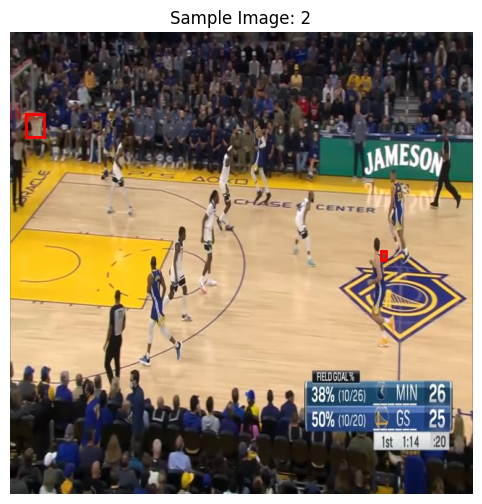

In [144]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Function to visualize a dataset sample
def visualize_sample(image, target, idx):
    """Visualize an image and its annotations from the dataset."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Convert the tensor image back to PIL for visualization
    image = TF.to_pil_image(image)
    ax.imshow(image)

    # Plot each bounding box in the image
    for box in target["boxes"].to(torch.int64):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    plt.title(f"Sample Image: {idx}")
    plt.axis('off')
    plt.show()

# Load a sample from the train dataset
sample_idx = 2  # You can change this to load different samples
sample_img, sample_target = train_dataset[sample_idx]

# Visualize the sample
visualize_sample(sample_img, sample_target, sample_idx)


Boxes shape for image 3: torch.Size([2, 4])


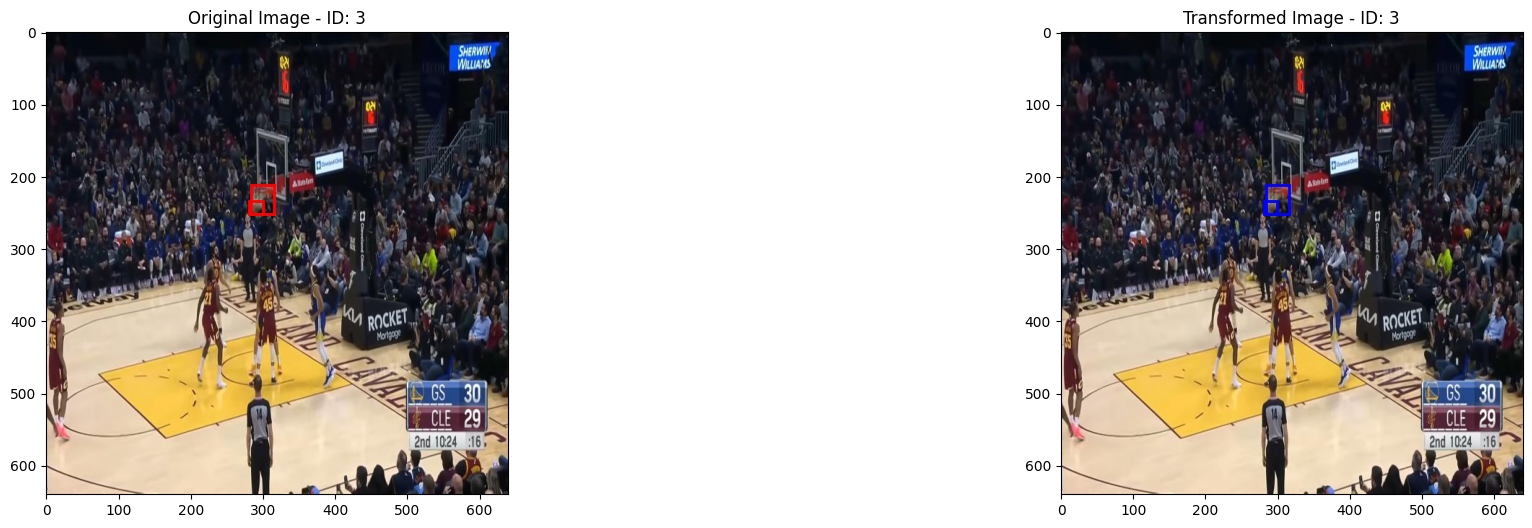

In [145]:
# Visualization (optional, for verification)
visualize_transformation(train_dataset, 3)  # Visualize the first image in the train dataset


Boxes shape for image 5: torch.Size([2, 4])
Visualizing BBox - xmin: 104.0, ymin: 300.0, xmax: 114.0, ymax: 317.77801513671875
Visualizing BBox - xmin: 419.0, ymin: 176.0, xmax: 439.0, ymax: 218.2220001220703


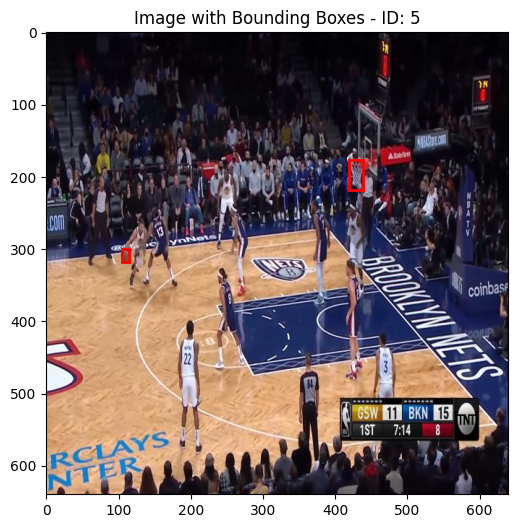

In [146]:

# Use this function to visualize
visualize_bbox(train_dataset, 5)  # Adjust index as needed

    CLASSES:
    people-rim-ball (id: 0)
    ball (id: 1)
    people (id: 2)
    rim (id: 3)

In [150]:
from engine import train_one_epoch, evaluate
from coco_utils import get_coco_api_from_dataset
from engine import _get_iou_types, train_one_epoch
from coco_eval import CocoEvaluator

# Modify this according to the number of classes in your dataset (including background)
num_classes = len(classes)+1  # Adjust as per your dataset

# get the model using our helper function inputting our number of classes from the 2 it's preset with
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_valid, device=device)

# Save the trained model weights
torch.save(model.state_dict(), 'models/model_weights.pth')

Boxes shape for image 55: torch.Size([2, 4])
Boxes shape for image 66: torch.Size([2, 4])
Epoch: [0]  [ 0/35]  eta: 0:00:05  lr: 0.000152  loss: 3.1629 (3.1629)  loss_classifier: 1.5943 (1.5943)  loss_box_reg: 0.0066 (0.0066)  loss_mask: 1.2514 (1.2514)  loss_objectness: 0.2920 (0.2920)  loss_rpn_box_reg: 0.0186 (0.0186)  time: 0.1640  data: 0.0110  max mem: 5247
Boxes shape for image 30: torch.Size([2, 4])
Boxes shape for image 41: torch.Size([1, 4])
Boxes shape for image 15: torch.Size([2, 4])
Boxes shape for image 64: torch.Size([2, 4])
Boxes shape for image 5: torch.Size([2, 4])
Boxes shape for image 67: torch.Size([2, 4])
Boxes shape for image 1: torch.Size([2, 4])
Boxes shape for image 28: torch.Size([2, 4])
Boxes shape for image 58: torch.Size([2, 4])
Boxes shape for image 45: torch.Size([2, 4])
Boxes shape for image 19: torch.Size([2, 4])
Boxes shape for image 23: torch.Size([2, 4])
Boxes shape for image 21: torch.Size([2, 4])
Boxes shape for image 13: torch.Size([2, 4])
Boxes 

Boxes shape for image 0: torch.Size([2, 4])


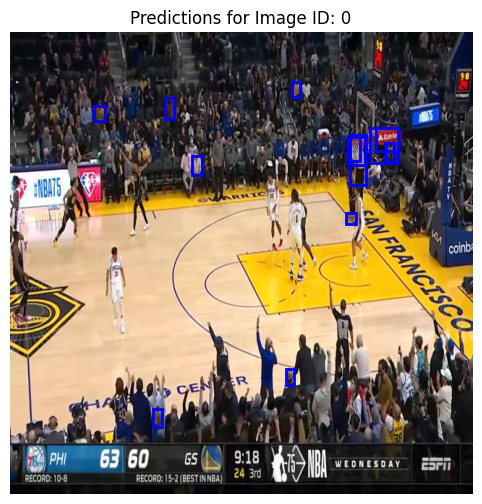

In [151]:
def visualize_predictions(dataset, model, idx, device):
    model.eval()
    img, _ = dataset[idx]
    img = img.to(device)
    with torch.no_grad():
        prediction = model([img])

    img = TF.to_pil_image(img.cpu())
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    for element in prediction[0]['boxes']:
        box = element.cpu().numpy()
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='blue', linewidth=2)
        plt.gca().add_patch(rect)
    plt.title(f"Predictions for Image ID: {idx}")
    plt.axis('off')
    plt.show()

# Visualize predictions on a sample from the validation set
visualize_predictions(valid_dataset, model, idx=0, device=device)

In [152]:
import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import matplotlib.pyplot as plt
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

def predict_and_visualize(image_path, model, device, threshold=0.5):
    # Read and transform the image
    image = read_image(image_path)
    eval_transform = get_transform(train=False)
    transformed_image = eval_transform(image)

    # Model inference
    model.eval()
    with torch.no_grad():
        x = transformed_image[:3, ...].to(device)  # Ensure RGB format
        prediction = model([x])[0]

    # Post-processing
    pred_scores = prediction['scores']
    pred_boxes = prediction['boxes']
    pred_labels = prediction['labels']
    pred_masks = prediction['masks']

    # Filter predictions based on threshold
    keep = pred_scores > threshold
    pred_boxes = pred_boxes[keep]
    pred_labels = pred_labels[keep]
    pred_masks = pred_masks[keep]

    # Draw bounding boxes and masks
    label_texts = [f'Label: {label.item()}, Score: {score:.3f}' for label, score in zip(pred_labels, pred_scores[keep])]
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]  # Ensure RGB format
    output_image = draw_bounding_boxes(image, pred_boxes, labels=label_texts, colors="red")
    output_image = draw_segmentation_masks(output_image, (pred_masks > 0.7).squeeze(1), alpha=0.5, colors="blue")

    # Visualization
    plt.figure(figsize=(12, 12))
    plt.imshow(output_image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
# Usage
model_path = 'models/model_weights.pth'  # Replace with your model's path
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Predict an image
image_path = '15282699.jpg'  # Replace with your image path
predict_and_visualize(image_path, model, device)


RuntimeError: [Errno 2] No such file or directory: '15282699.jpg'

In [ ]:
import yt_dlp

video_urls = [
    "https://www.youtube.com/watch?v=QrN5dO00fgc"

]

output_path = 'data'

ydl_opts = {
    'format': 'best',
    'outtmpl': output_path + '/%(title)s.%(ext)s',
    'quiet': True
}

failed_downloads = []
successful_downloads = []

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    for url in video_urls:
        try:
            ydl.download([url])
            print(f"Successfully downloaded {url}")
            successful_downloads.append(url)
        except Exception as e:
            print(f"Failed to download {url}: {e}")
            failed_downloads.append(url)    

print(f"Successfully downloaded {len(successful_downloads)} videos.")
print(f"Failed to download {len(failed_downloads)} videos.")


# Replace 'link' with the actual YouTube video link
video_path = output_path + '\Warriors vs Cavaliers： Game 7 NBA Finals - 06.19.16 Full Highlights.mp4'

Successfully downloaded https://www.youtube.com/watch?v=QrN5dO00fgc
Successfully downloaded 1 videos.
Failed to download 0 videos.


In [153]:
import json

def load_classes_from_json(file_path):
    """
    Loads the class names and their corresponding IDs from a COCO format JSON file.

    Args:
    file_path (str): Path to the JSON file.

    Returns:
    dict: A dictionary where keys are class IDs and values are class names.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extracting classes and their IDs
    classes = {category['id']: category['name'] for category in data['categories']}
    return classes

# Usage example:
classes = load_classes_from_json('Basketball-and-Hoop-2/test/_annotations.coco.json')
print(classes)

{0: 'Basketball-and-Hoop', 1: 'Basketball', 2: 'Hoop'}


In [154]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [155]:
# Modify this according to the number of classes in your dataset (including background)
num_classes = len(classes)+1  # Adjust as per your dataset

# get the model using our helper function inputting our number of classes from the 2 it's preset with
model = get_model_instance_segmentation(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Usage
model_path = 'models/model_weights.pth'  # Replace with your model's path
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Usage
video_path = 'data/Stephen Curry’s Top 30 Career 3-Pointers 💦.mp4'




In [156]:
import cv2
import torch
from torchvision.transforms import v2 as T
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

def process_video(video_path, model, device, threshold=0.5):
    model.eval()

    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to tensor
        frame_tensor = T.ToTensor()(frame).unsqueeze_(0).to(device)

        # Model inference
        with torch.no_grad():
            prediction = model(frame_tensor)[0]

        # Post-processing
        pred_scores = prediction['scores']
        pred_boxes = prediction['boxes']
        pred_labels = prediction['labels']
        pred_masks = prediction['masks']

        # Filter predictions based on threshold
        keep = pred_scores > threshold
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]
        pred_masks = pred_masks[keep]

        # Draw bounding boxes and masks
        label_texts = [f'Label: {label.item()}, Score: {score:.3f}' for label, score in zip(pred_labels, pred_scores[keep])]
        frame_tensor = (255.0 * (frame_tensor - frame_tensor.min()) / (frame_tensor.max() - frame_tensor.min())).to(torch.uint8)
        frame_tensor = frame_tensor.squeeze().to(torch.uint8)
        output_image = draw_bounding_boxes(frame_tensor, pred_boxes, labels=label_texts, colors="red")
        output_image = draw_segmentation_masks(output_image, (pred_masks > 0.7).squeeze(1), alpha=0.5, colors="blue")

        # Convert tensor back to image for display
        output_image = output_image.permute(1, 2, 0).cpu().numpy()

        # Display the resulting frame
        cv2.imshow('Frame', output_image)

        # Break the loop with 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release everything when done
    cap.release()
    cv2.destroyAllWindows()

threshold = 0.5  # Adjust as needed

# Usage
video_path = video_path  # Replace with your video path
process_video(video_path, model, device, threshold=threshold)
